In [1]:
### Packages used

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from sklearn.model_selection import GridSearchCV
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import string
import ast
import json

In [2]:
### Dataset
movies_metadata = pd.read_csv('movies_metadata.csv')


/var/folders/yl/nm9q5skx4kl66ty6qt9_rhyh0000gp/T/ipykernel_55437/4180892808.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('movies_metadata.csv')


In [3]:
# Due to the size of the dataset, I will take a 10% representative sample
movies_df = movies_metadata.sample(frac=0.1, random_state=42)


In [4]:
#Inspect dataset

pd.set_option('max_colwidth', None)
movies_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4547 entries, 43526 to 42930
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  4547 non-null   object 
 1   belongs_to_collection  424 non-null    object 
 2   budget                 4547 non-null   object 
 3   genres                 4547 non-null   object 
 4   homepage               794 non-null    object 
 5   id                     4547 non-null   object 
 6   imdb_id                4546 non-null   object 
 7   original_language      4547 non-null   object 
 8   original_title         4547 non-null   object 
 9   overview               4455 non-null   object 
 10  popularity             4546 non-null   object 
 11  poster_path            4506 non-null   object 
 12  production_companies   4546 non-null   object 
 13  production_countries   4546 non-null   object 
 14  release_date           4534 non-null   object 
 15 

In [5]:
#Check number of missing values in each column

movies_df.isna().sum()


adult                       0
belongs_to_collection    4123
budget                      0
genres                      0
homepage                 3753
id                          0
imdb_id                     1
original_language           0
original_title              0
overview                   92
popularity                  1
poster_path                41
production_companies        1
production_countries        1
release_date               13
revenue                     1
runtime                    25
spoken_languages            1
status                      6
tagline                  2508
title                       1
video                       1
vote_average                1
vote_count                  1
dtype: int64

In [6]:
#Remove columns not needed - these are removed as they either have a large amount of NAs or they aren't a good feature for the model (text data)

movies_df = movies_df.drop(["adult", "title", "original_title", "imdb_id", "production_companies", "release_date", "belongs_to_collection","spoken_languages", "poster_path", "status", "video", "homepage","popularity", "vote_count"], axis=1)


In [7]:
#Remove records that are NAs - since the number is small, removing the NAs is a suitable approach

movies_df = movies_df.dropna(subset=['original_language', 'production_countries', 'revenue', 'runtime', 'vote_average'])

In [8]:
# Convert revenue column to numeric data type
movies_df["revenue"] = pd.to_numeric(movies_df["revenue"], errors="coerce")

# Check for NaN or infinite values in the revenue column
print(np.isnan(movies_df["revenue"]).sum())
print(np.isinf(movies_df["revenue"]).sum())

0
0


In [9]:
# Check the average revenue - 10 billion dollars

movies_df.revenue.mean()

10100131.069880584

In [10]:
# Check correlation between variables using a correlation matrix - the correlation of 0.775 indicates a positive correlation between budget and revenue

movies_df["budget"] = pd.to_numeric(movies_df["budget"], errors="coerce")


corr_coeff = movies_df['budget'].corr(movies_df['revenue'])

print(corr_coeff)

0.7857552596645303


## Feature engineering
 - create a binary variable to show whether the movie has a tagline or not (1 and 0)
 - separate genres and use hot encoding to represent them numerically
 - re-code the language the movie was produced as a numeric variable
 - calculate the length of the movie overview

#### Create a binary variable to show whether the movie has a tagline or not (1 and 0) - I suspect that having a tagline will positively impact on revenue


In [11]:
movies_df['binary_tagline'] = movies_df['tagline'].notnull().astype(int)


In [12]:
#Check variable -we have slightly more movies with taglines than not

movies_df.binary_tagline.value_counts()


0    2483
1    2039
Name: binary_tagline, dtype: int64

#### Separe genres - currently each movie has a few genres. We need to create separate columns for each genre and have 1 or 0 if the movie is in that category.

In [13]:
movies_df['genres'] = movies_df['genres'].astype(str)

In [14]:
def extract_genre_names(row):
    genres = json.loads(row.replace("'", "\""))
    genres = [genre['name'] for genre in genres]
    return '|'.join(genres)

# apply function to each row of 'genres' column and create new column 'genre_names'
movies_df['genre_names'] = movies_df['genres'].apply(extract_genre_names)


In [15]:
# create binary columns for each genre
genre_columns = movies_df['genre_names'].str.get_dummies('|')

# concatenate binary columns with original DataFrame
movies_df = pd.concat([movies_df, genre_columns], axis=1)


### Re-code the language the movie was produced as a numeric variable

In [16]:
# Remove movies that are in less popular languages 

# get the count of movies by each language
language_counts = movies_df['original_language'].value_counts()

#language_counts


In [17]:
# We will keep only the top 10 languages as they cover 92% of the dataset: 
# english, french, italian, japanese, german,  spanish, russian, hindi, chinese, sweedish

movies_df = movies_df[movies_df['original_language'].isin(['en', 'fr', 'it', 'ja', 'de', 'es', 'ru', 'hi', 'zh', 'sv'])]

In [18]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# Encode the 'original_language' column as numeric values

movies_df['original_language_encoded'] = le.fit_transform(movies_df['original_language'])

#### Length of movie overview - I will clean the 'overview' column, remove punctuation and special characters and tokenize each row to find the length of each movie overview. I have a 'hypothesis' that the length of the overview is important

In [19]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    """
    This function removes stopwords, punctuation, and special characters, and tokenizes the text in each row.
    """
    if pd.isnull(text):
        return ''
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text


In [20]:
movies_df['cleaned_overview'] = movies_df['overview'].apply(clean_text)

##Count length of text in each row
movies_df['overview_length'] = movies_df.apply(lambda row: len(row['cleaned_overview']), axis=1)


#### Use EmoBert to extract emotions from the overview of the movie. This is a trained language model that can recognize and understand emotions in text. Again, I have a 'hypothesis' that the emotion of the movie overview is an important factor when it comes to revenue.

The 18 emotions returned by EmoBert are:

1.amusement,
2.anger,
3.awe,
4.awkwardness,
5.boredom,
6.calmness,
7.confusion,
8.craving,
9.disgust,
10.empathetic pain,
11.excitement,
12.fear,
13.horror,
14.interest,
15.joy,
16.nostalgia,
17.romance,
18.sadness

In [21]:
# Load the EmoBert model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-emoji"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [22]:
# Define a function to predict the emotion of a text using EmoBert
def predict_emotion(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt")
    # Make a prediction
    outputs = model(**inputs)
    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits)
    # Return the predicted label as an integer
    return int(predicted_label)

# Apply the predict_emotion function to the 'overview' column and create a new column 'overview_emotion'
movies_df['overview_emotion'] = movies_df['cleaned_overview'].apply(predict_emotion)

### Decision tree Regression model - as the outcome variable is numeric, I am using a regression decision tree to predict revenue.

In [23]:
# Define the features (X) and target (y)
X = movies_df[['budget','runtime', 'vote_average', 'overview_length', 'binary_tagline', 'original_language_encoded', 
               'overview_emotion']]

y = movies_df['revenue']

In [24]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Print the shapes of the training and testing sets

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (3332, 7) (3332,)
Testing set shape: (834, 7) (834,)


In [26]:
# Training the DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [27]:
# Training Accuracy - as result is 100% , there might be some over-fitting with the data

y_pred_train = dt_regressor.predict(X_train)
r2_score(y_train, y_pred_train)

1.0

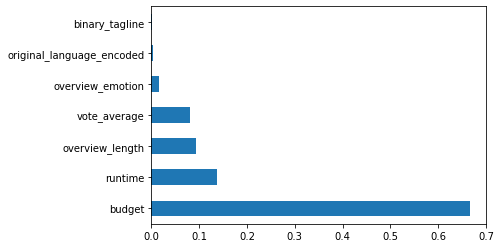

In [28]:
# Check feature importance - the budget is the most important feature in the model, with the overview_length second and the average vote for the movie third. 

feat_importances = pd.Series(dt_regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [29]:
#Testing Accuracy - on unseen data the model perform quite well - with an accuracy of 67%

y_pred = dt_regressor.predict(X_test)
r2_score(y_test, y_pred)

0.6832739922136006

In [30]:
# Run performance metrics without hyperparameter tuning - they are all high, which is not good. For regression problems, a good model would have low error rates but this is not the case here. 
#It could be that more features are needed for the analysis to be more roboust.

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 7795651.805755395
MSE: 1038629147102522.6
RMSE: 32227769.81273328


### Hyperparameter Tunning

As the accuracy on unseen data was 47%, I am tuning to hyperamater tunning. For this I picked the grid search method because regression decision trees have many hyperparameters, and finding the optimal combination can be time-consuming and challenging manually. With grid search, we can automate the process and ensure that we are exploring the entire hyperparameter space, thus maximizing the chances of finding the best set of hyperparameters.  I am looking to improve 6 hyperparameters.
- max_depth: The maximum depth of the decision tree.
- max_features: The number of features to consider when looking for the best split.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- min_samples_split: The minimum number of samples required to split an internal node.
- criterion: The function used to measure the quality of a split.
- splitter: The strategy used to choose the split at each node.

In [31]:
# Hyper parameters range initialization for tuning
param_grid = {
    'max_depth': [80, 90, 100, None],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'splitter': ["best", "random"]
}

# Create the decision tree regressor object 
dt_regressor = DecisionTreeRegressor(random_state = 0) #random_state of 0 so the analysis is reproducible

# Create the grid search object
grid_search = GridSearchCV(estimator = dt_regressor, param_grid = param_grid, cv = 10, verbose = 2, scoring = 'r2', n_jobs = -1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train);

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable T

In [32]:
# Get the best model from the grid search

best_model = grid_search.best_estimator_


#### Training Accuracy - The code is using the best model that was identified during the grid search to make predictions on the training set


In [33]:
# Use the best model to make predictions
y_pred = best_model.predict(X_train)

# Compute the R-squared score of the model on the training data - accuracy decreased from 100% to 74%
r2_score(y_train, y_pred)

0.7353187144362914

#### Testing Training Accuracy - The code is using the best model obtained from a grid search to make predictions on the testing set and evaluating the model's performance using the R-squared score.


In [34]:
# Compute the R-squared score of the model on the testing data - accuracy decreased from 67% to 65%

y_pred = best_model.predict(X_test)
r2_score(y_test, y_pred)

0.6467791892197275

#### Review Performance Metrics

In [35]:
# With hyperparameter tuned - even though the accuracy increased, the metrics are very high which means that the model is not roboust enough.

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 7862301.003335247
MSE: 1158305350430807.0
RMSE: 34033885.32669767


## Regression Decision Tree Results

The results show that the decision tree regressor model has a training accuracy of 100%, which suggests that it might have overfit the training data. However, the testing accuracy was 67%, indicating that the model is performing fine on unseen data. To improve the model's performance, hyperparameter tuning is done using grid search with cross-validation. The best model from the grid search has a training accuracy of 74% and a testing accuracy of 65%, which suggests that the hyperameter tunning did not have a significant impact on the model. Overall, the model can be used to predict the revenue of a movie based on its budget, runtime, vote average, overview length, binary tagline, original language, and the emotion of the movie overview, but further analysis is needed to determine if the model is suitable for practical use. The error rates suggest that the model is not very accurate in predicting the revenue of the movies. The mean absolute error (MAE) of 7862301.0 suggests that, on average, the model's revenue predictions are off by that amount ($). The mean squared error (MSE) and root mean squared error (RMSE) are also quite large, which further confirms that the model is not very accurate.

# Random Forest Model - use a second model to improve accuracy and minimise errors

In [36]:
from sklearn.ensemble import RandomForestRegressor


In [37]:
# Define the features (X) and target (y)
X = movies_df[['budget','runtime', 'vote_average', 'overview_length', 'binary_tagline', 'original_language_encoded', 
               'overview_emotion']]

y = movies_df['revenue']

In [38]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Create a random forest regressor with 100 trees and a random seed of 0

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

In [42]:
# Fits the random forest regressor model to the training set

rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [43]:
# Evaluating the performance of the trained RandomForestRegressor model on the training set by calculating the R-squared (coefficient of determination) metric. 

y_pred_train = rf_regressor.predict(X_train)
r2_score(y_train, y_pred_train)

0.9446692787230528

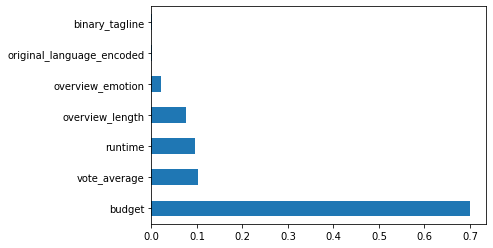

In [44]:
feat_importances = pd.Series(rf_regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [46]:
# Evaluating the performance of the trained RandomForestRegressor model on the testing set by calculating the R-squared (coefficient of determination) metric - better than our decision tree!

y_pred = rf_regressor.predict(X_test)
r2_score(y_test, y_pred)

0.7262543045251166

In [49]:
# Without hyperparameter tuned - the error rates are smaller compared to the regression decision tree

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 7538434.896258992
MSE: 897685227055338.9
RMSE: 29961395.612610217


### Hyperparameter Tunning - to further increase the accuracy and minimise model error, we will use Grid Search to tune the Random Forest Hyperparameters.

There are 6 hyperparameters that are tuned:
 - n_estimators: The number of decision trees in the random forest ensemble. Increasing this value can improve the performance of the model, but also increases the training time and memory requirements.

 - max_depth: The maximum depth of each decision tree in the random forest ensemble. A deeper tree can capture more complex patterns in the data, but can also lead to overfitting. Setting this to None means that the trees will be expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

 - max_features: The maximum number of features to consider when making a split in each decision tree. This can help reduce overfitting and speed up training. Setting this to None means that all features are used.

 - min_samples_leaf: The minimum number of samples required to be at a leaf node. Setting this to a larger value can help prevent overfitting by requiring each leaf to have more samples.

 - min_samples_split: The minimum number of samples required to split an internal node. Setting this to a larger value can help prevent overfitting by requiring more samples to be present in each split.

 - criterion: The function used to measure the quality of a split. The available options are squared_error (MSE), mae (MAE), and absolute_error (MAE with absolute error). MSE is the default and typically works well for regression tasks.

In [54]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [80, 90, 100, None],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'criterion': ["squared_error", "absolute_error"]
}


In [55]:
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=10, verbose=2, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable T

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [80, 90, 100, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 20, 30]},
             scoring='r2', verbose=2)

In [56]:
# Using the best_estimator_ attribute of a GridSearchCV object to obtain the best hyperparameters that were found during hyperparameter tuning,
# and then using those hyperparameters to create the best model. The best model is then used to make predictions on the training set. 

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

In [57]:
# Compute the R-squared score of the model on the training data 
r2_score(y_train, y_pred)

0.7825877928936914

In [58]:
# Using the best_estimator_ attribute of a GridSearchCV object to obtain the best hyperparameters that were found during hyperparameter tuning,
# and then using those hyperparameters to create the best model. The best model is then used to make predictions on the test set. 

y_pred = best_model.predict(X_test)

In [59]:
# Compute the R-squared score of the model on the testing data 
r2_score(y_test, y_pred)

0.6811404780058778

In [61]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 7789857.109526528
MSE: 1045625509849571.2
RMSE: 32336133.19260006


## Random Forest Model Results

Based on the results, after using hyperparameter tunning, the random forest model has an accuracy of 69% . This accuracy is higher than the accuracy from the Regression Decision Tree model, which was 64%. The Random Forest Model also shows slightly lower errors than the Regression Decision Tree Model. With a MAE of 7789857.1, MSE of 1045625509849571 and RMSE of 32336133, compared to the Regression Decision Tree which had a MAE of 7862301, a MSE of 1158305350430807.0 and RMSE of 34033885.3. However, the error rates are still high, which indicates that important features might be missing from the analysis. Based on the two models, I recommend the random forest model as it gives a higher accuracy and a lower error rate. Emsemble techniques are better than decision trees as they can capture the complexity of the data or where the data is noisy or uncertain.